In [ ]:
import sys
print(sys.version)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load Dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.isnull().sum())
df.drop('customerID', axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [ ]:
#  Encode Target
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [ ]:
#  Binary Encoding
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})
df.replace(['No internet service', 'No phone service'], 'No', inplace=True)


In [ ]:

# One-Hot Encoding
df = pd.get_dummies(df, drop_first=True)

In [ ]:
# Feature Scaling
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols] = scaler.fit_transform(df[num_cols])

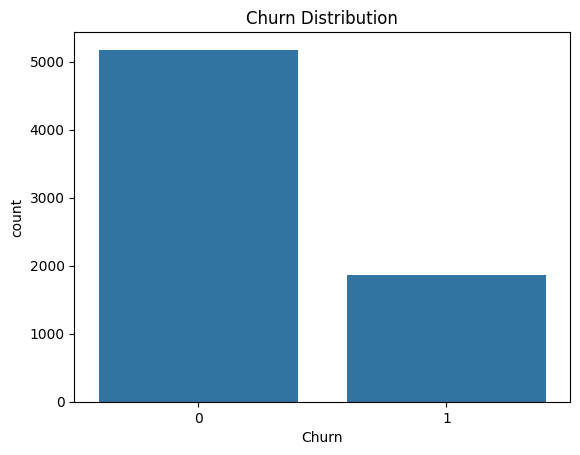

In [ ]:
# Exploratory Data Analysis (EDA)
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

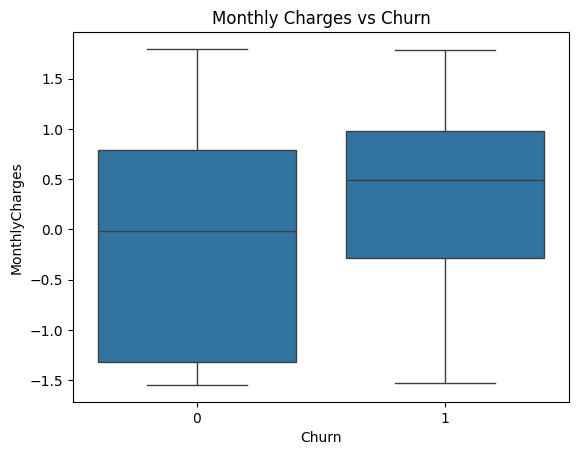

In [ ]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges vs Churn")
plt.show()

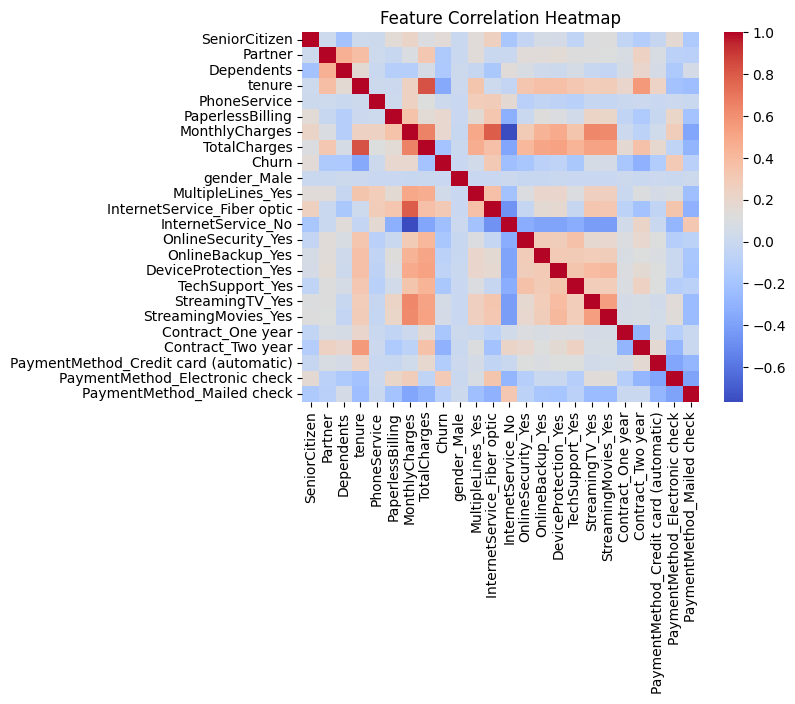

In [ ]:
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Prepare Features
X = df.drop('Churn', axis=1)
y = df['Churn']
joblib.dump(X.columns.tolist(), "train_columns.pkl")

['train_columns.pkl']

In [ ]:
#  Handle Class Imbalance
X_res, y_res = SMOTE(random_state=42).fit_resample(X, y)



In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [ ]:

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

=== Logistic Regression Report ===
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1021
           1       0.79      0.83      0.81      1049

    accuracy                           0.80      2070
   macro avg       0.80      0.80      0.80      2070
weighted avg       0.80      0.80      0.80      2070



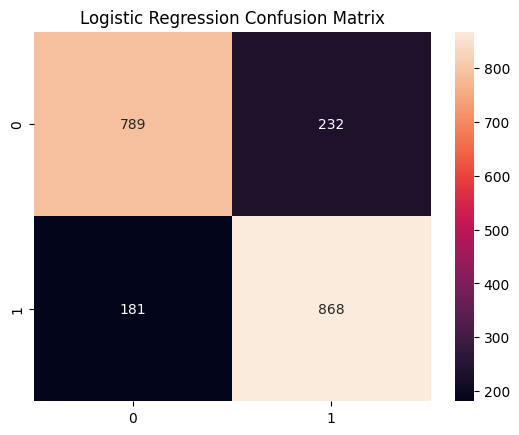

['logistic_model.pkl']

In [ ]:
print("=== Logistic Regression Report ===")
print(classification_report(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d')
plt.title("Logistic Regression Confusion Matrix")
plt.show()
joblib.dump(lr_model, "logistic_model.pkl")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 1],
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=20, cv=3, scoring='f1', n_jobs=-1)
random_search.fit(X_train, y_train)

xgb_model = random_search.best_estimator_
y_pred_ = xgb_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1021
           1       0.83      0.88      0.85      1049

    accuracy                           0.85      2070
   macro avg       0.85      0.85      0.85      2070
weighted avg       0.85      0.85      0.85      2070



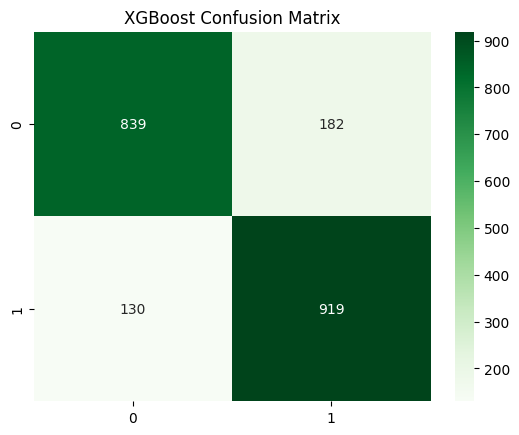

['xgb_model.pkl']

In [ ]:

print(classification_report(y_test, y_pred_))
sns.heatmap(confusion_matrix(y_test, y_pred_), annot=True, fmt='d', cmap='Greens')
plt.title("XGBoost Confusion Matrix")
plt.show()
joblib.dump(xgb_model, "xgb_model.pkl")

In [ ]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
rf_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=30, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)
rf = rf_search.best_estimator_
y_pred_rf = rf.predict(X_test)


=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1021
           1       0.85      0.87      0.86      1049

    accuracy                           0.86      2070
   macro avg       0.86      0.86      0.86      2070
weighted avg       0.86      0.86      0.86      2070



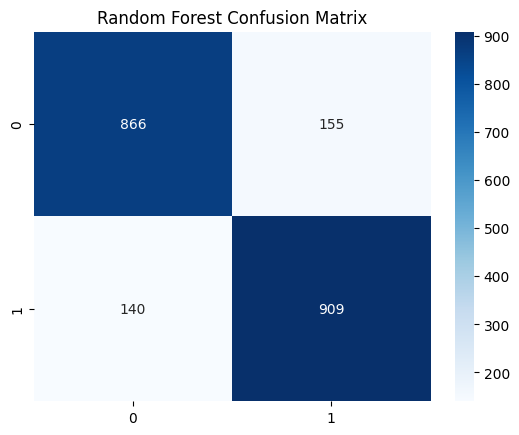

In [ ]:
# Evaluate Random Forest
print("=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

In [ ]:
# Save the model
joblib.dump(rf, "rf_model.pkl")

['rf_model.pkl']

In [ ]:
#model evaluation

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{name} Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print("-" * 40)

In [ ]:
print("\n=== Model Performance Summary ===\n")
evaluate_model("Logistic Regression", y_test, y_pred_lr)
evaluate_model("XGBoost", y_test, y_pred_)
evaluate_model("Random Forest", y_test, y_pred_rf)


=== Model Performance Summary ===

Logistic Regression Metrics:
Accuracy : 0.8005
Precision: 0.7891
Recall   : 0.8275
F1-Score : 0.8078
----------------------------------------
XGBoost Metrics:
Accuracy : 0.8493
Precision: 0.8347
Recall   : 0.8761
F1-Score : 0.8549
----------------------------------------
Random Forest Metrics:
Accuracy : 0.8575
Precision: 0.8543
Recall   : 0.8665
F1-Score : 0.8604
----------------------------------------


In [ ]:
import json

metrics = {
    "Logistic Regression": {
        "Accuracy": accuracy_score(y_test, y_pred_lr),
        "Precision": precision_score(y_test, y_pred_lr),
        "Recall": recall_score(y_test, y_pred_lr),
        "F1-Score": f1_score(y_test, y_pred_lr)
    },
    "XGBoost": {
        "Accuracy": accuracy_score(y_test, y_pred_),
        "Precision": precision_score(y_test, y_pred_),
        "Recall": recall_score(y_test, y_pred_),
        "F1-Score": f1_score(y_test, y_pred_)
    },
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "Precision": precision_score(y_test, y_pred_rf),
        "Recall": recall_score(y_test, y_pred_rf),
        "F1-Score": f1_score(y_test, y_pred_rf)
    }
}

with open("model_metrics.json", "w") as f:
    json.dump(metrics, f)
